In [ ]:
# https://www.kaggle.com/code/rounakbanik/movie-recommender-systems -> 참고 코드
# data_set = https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?datasetId=3405&sortBy=voteCount

In [1]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 8.3 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633975 sha256=b75a4e9bd08864bb08021ee22390a31291ad6439643e403ad6b6281f4b6668c1
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

import warnings; warnings.simplefilter('ignore')

# simple Recommender

In [3]:
md = pd. read_csv('/content/drive/MyDrive/KaggleData/movie/movies_metadata.csv')
md.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [4]:
md.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [5]:
md.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

## literal_eval

In [ ]:
# literal_eval은 문자열을 딕셔너리/리스트 형태로 바꿔줄 수 있다. 
# literal_eval 기능을 사용하기 위해선 ast 모듈을 알고 있어야 한다. ast는 Abstract Syntax Trees의 약자로 문법을 구조화 시켜주는 모듈이다.
# genres가 복잡하게 리스트 안의 딕셔너리 형태로 있어서 사용하는 듯. 
# md['genres']를 md['genres']에 결측치를 []로 넣어준다. 

## isinstance


In [ ]:
# isinstance(확인하고자 하는 데이터 값, 확인하고자 하는 데이터 타입)
# 첫 번째 매개변수 : 확인하고자 하는 데이터의 값, 객체, 인스턴스
# 두 번째 매개변수 : 확인하고자 하는 데이터의 타입, 클래스
# 반환 값 : 인스턴스와 타입이 같으면 True를 반환하고, 다르면 False를 반환


## Test로 확인해보기

In [ ]:
# 예시)
# [{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]

In [10]:
# Test Dataframe 생성
test = {'genres': [1, 2, 3, 4]}
test

{'genres': [1, 2, 3, 4]}

In [11]:
test['genres'] = md['genres'].fillna('[]')
test
# -> test['genres']가 md['genres']로 copy 되면서 na가 '[]'로 채워짐

{'genres': 0        [{'id': 16, 'name': 'Animation'}, {'id': 35, '...
 1        [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...
 2        [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...
 3        [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
 4                           [{'id': 35, 'name': 'Comedy'}]
                                ...                        
 45461    [{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...
 45462                        [{'id': 18, 'name': 'Drama'}]
 45463    [{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...
 45464                                                   []
 45465                                                   []
 Name: genres, Length: 45466, dtype: object}

In [12]:
test['genres'] = md['genres'].fillna('[]').apply(literal_eval)
test
# -> literal_eval로 형변환 이루어진듯? 겉으로 봤을 때에는 차이가 없다. 

{'genres': 0        [{'id': 16, 'name': 'Animation'}, {'id': 35, '...
 1        [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...
 2        [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...
 3        [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
 4                           [{'id': 35, 'name': 'Comedy'}]
                                ...                        
 45461    [{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...
 45462                        [{'id': 18, 'name': 'Drama'}]
 45463    [{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...
 45464                                                   []
 45465                                                   []
 Name: genres, Length: 45466, dtype: object}

In [13]:
test['genres'] = md['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
test
# -> 'genres'에 name에 해당하는 값만 남아있게 되었음.

{'genres': 0         [Animation, Comedy, Family]
 1        [Adventure, Fantasy, Family]
 2                   [Romance, Comedy]
 3            [Comedy, Drama, Romance]
 4                            [Comedy]
                      ...             
 45461                 [Drama, Family]
 45462                         [Drama]
 45463       [Action, Drama, Thriller]
 45464                              []
 45465                              []
 Name: genres, Length: 45466, dtype: object}

In [14]:
md['genres'] = md['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [15]:
md['genres']

0         [Animation, Comedy, Family]
1        [Adventure, Fantasy, Family]
2                   [Romance, Comedy]
3            [Comedy, Drama, Romance]
4                            [Comedy]
                     ...             
45461                 [Drama, Family]
45462                         [Drama]
45463       [Action, Drama, Thriller]
45464                              []
45465                              []
Name: genres, Length: 45466, dtype: object

## qualified 필터링 하기 

In [16]:
print(md['vote_count'].dtype)
print(md['vote_average'].dtype)

float64
float64


In [17]:
md['vote_count'].notnull()

0        True
1        True
2        True
3        True
4        True
         ... 
45461    True
45462    True
45463    True
45464    True
45465    True
Name: vote_count, Length: 45466, dtype: bool

In [18]:
md['vote_count'].unique()

array([5415., 2413.,   92., ..., 2083., 2002., 2712.])

In [19]:
md['vote_average'].mean()

5.618207215134185

In [20]:
# vote_counts와 vote_average를 float에서 int로 변환 
# count는 어차피 자연수지만, vote_average는..?  내림으로 변환됨.
vote_counts = md[md['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = md[md['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
C

5.244896612406511

In [21]:
vote_averages.unique

<bound method Series.unique of 0        7
1        6
2        6
3        6
4        5
        ..
45461    4
45462    9
45463    3
45464    0
45465    0
Name: vote_average, Length: 45460, dtype: int64>

In [22]:
vote_averages.nunique()
#  -> 0 ~ 10까지 11가지의 수로 변환 

11

In [23]:
vote_counts.describe()

count    45460.000000
mean       109.897338
std        491.310374
min          0.000000
25%          3.000000
50%         10.000000
75%         34.000000
max      14075.000000
Name: vote_count, dtype: float64

In [24]:
print(vote_counts.quantile(0.90))
print(vote_counts.quantile(0.5))
print(vote_counts.quantile(0.3))

160.0
10.0
4.0


In [25]:
# https://www.geeksforgeeks.org/python-pandas-dataframe-quantile/
# pandas quantile q means 0 <= q <= 1

In [26]:
# 상위 5% 값을 기준으로 삼기 위해 m을 따로 할당
m = vote_counts.quantile(0.95)
m

434.0

In [ ]:
#  If 'coerce', then invalid parsing will be set as NaT. 바꿔줄 date가 없으면 NaT로 바꾼다.
#  나머지 errors 로는 1. raise -> exception 예외를 발생시킨다.
# 3 또 다른 하나는 ignore -> 그냥 입력값을 그대로 유지시킨다. 

In [27]:
md['year'] = pd.to_datetime(md['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [ ]:
# qualified -> 공인된 영화만을 뽑아내는 작업(dataframe)
# 1. vote_count 가 앞서 언급했던 m 이상인것들로만 AND
# 2. vote_count 가 null이 아닌 것 AND
# 3. vote_average 가 null 이 아닌 것
# 4. 중에서 title, year, vote_count, vote_average, popularity, genres만 가져온다.
# 5. vote_count int로 변환
# 6. voute_average int로 변환 

In [28]:
qualified = md[(md['vote_count'] >= m) & (md['vote_count'].notnull()) & (md['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(2274, 6)

In [32]:
qualified

,title,year,vote_count,vote_average,popularity,genres,wr
0,Toy Story,1995,5415,7,21.946943,"[Animation, Comedy, Family]",6.869770
1,Jumanji,1995,2413,6,17.015539,"[Adventure, Fantasy, Family]",5.884891
5,Heat,1995,1886,7,17.924927,"[Action, Crime, Drama, Thriller]",6.671675
9,GoldenEye,1995,1194,6,14.686036,"[Adventure, Action, Thriller]",5.798701
15,Casino,1995,1343,7,10.137389,"[Drama, Crime]",6.571348
...,...,...,...,...,...,...,...
44624,What Happened to Monday,2017,598,7,60.581223,"[Science Fiction, Thriller]",6.261904
44632,Atomic Blonde,2017,748,6,14.455104,"[Action, Thriller]",5.722745
44678,Dunkirk,2017,2712,7,30.938854,"[Action, Drama, History, Thriller, War]",6.757878
44842,Transformers: The Last Knight,2017,1440,6,39.186819,"[Action, Science Fiction, Thriller, Adventure]",5.825125


In [33]:
qualified.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2274 entries, 0 to 45014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         2274 non-null   object 
 1   year          2274 non-null   object 
 2   vote_count    2274 non-null   int64  
 3   vote_average  2274 non-null   int64  
 4   popularity    2274 non-null   object 
 5   genres        2274 non-null   object 
 6   wr            2274 non-null   float64
dtypes: float64(1), int64(2), object(4)
memory usage: 142.1+ KB


## Weight 설정하기 

In [ ]:
# Weighted Rating (WR) =  (vv+m.R)+(mv+m.C)
# v is the number of votes for the movie
# m is the minimum votes required to be listed in the chart
# R is the average rating of the movie
# C is the mean vote across the whole report

In [29]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [30]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

In [34]:
qualified = qualified.sort_values('wr', ascending=False).head(250)

## Top movies

In [35]:
qualified.head(15)

,title,year,vote_count,vote_average,popularity,genres,wr
15480,Inception,2010,14075,8,29.108149,"[Action, Thriller, Science Fiction, Mystery, A...",7.917588
12481,The Dark Knight,2008,12269,8,123.167259,"[Drama, Action, Crime, Thriller]",7.905871
22879,Interstellar,2014,11187,8,32.213481,"[Adventure, Drama, Science Fiction]",7.897107
2843,Fight Club,1999,9678,8,63.869599,[Drama],7.881753
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.070725,"[Adventure, Fantasy, Action]",7.871787
292,Pulp Fiction,1994,8670,8,140.950236,"[Thriller, Crime]",7.868660
314,The Shawshank Redemption,1994,8358,8,51.645403,"[Drama, Crime]",7.864000
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.324358,"[Adventure, Fantasy, Action]",7.861927
351,Forrest Gump,1994,8147,8,48.307194,"[Comedy, Drama, Romance]",7.860656
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.423537,"[Adventure, Fantasy, Action]",7.851924


## Percentile 재조정

In [ ]:
# 재조정 하는 이유 -> 인셉션, 다크나이트, 인터스텔라 모두 크리스토퍼 놀란 감독의 작품
# TMDB 사용자들의 특정 장르와 감독에 대한 강한 편의가 있는 것을 보여준다
# 특정한 장르에 대해 새롭게 차트를 만들어 보고 영화 리스트의 범위를 넓히기 위해
# percentile 0.95(상위 5%의 영화) -> 0.85(상위 15%의 영화)로 재조정한다.

In [ ]:
# genres 의 개별 장르 하나하나를 꺼내서 stack(쌓아 올린다)
# 그 결과로 s는 시리즈 형태로 반환된다. 

In [36]:
s = md.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_md = md.drop('genres', axis=1).join(s)

In [39]:
s

0        Animation
0           Comedy
0           Family
1        Adventure
1          Fantasy
           ...    
45461       Family
45462        Drama
45463       Action
45463        Drama
45463     Thriller
Name: genre, Length: 91106, dtype: object

In [42]:
type(s)

pandas.core.series.Series

In [45]:
s.dtype

dtype('O')

In [46]:
print(s)

0        Animation
0           Comedy
0           Family
1        Adventure
1          Fantasy
           ...    
45461       Family
45462        Drama
45463       Action
45463        Drama
45463     Thriller
Name: genre, Length: 91106, dtype: object


In [47]:
gen_md

,adult,belongs_to_collection,budget,homepage,id,imdb_id,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,genre
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995,Animation
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995,Comedy
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995,Family
1,False,NaN,65000000,NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,Adventure
1,False,NaN,65000000,NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,Fantasy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45463,False,NaN,0,NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",0.903007,...,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0,2003,Action
45463,False,NaN,0,NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",0.903007,...,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0,2003,Drama
45463,False,NaN,0,NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",0.903007,...,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0,2003,Thriller
45464,False,NaN,0,NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",0.003503,...,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0,1917,NaN


In [ ]:
# build_chart는 위에서 사용한 것들을 하나의 함수롤 합친 것. 
# 인자로 장르 입력, penctile도 마음껏 바꿀 수 있다. 

In [48]:
def build_chart(genre, percentile=0.85):
    df = gen_md[gen_md['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    
    qualified['wr'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(250)
    
    return qualified

## Top Romance movies

In [49]:
build_chart('Romance').head(15)

,title,year,vote_count,vote_average,popularity,wr
10309,Dilwale Dulhania Le Jayenge,1995,661,9,34.457024,8.565285
351,Forrest Gump,1994,8147,8,48.307194,7.971357
876,Vertigo,1958,1162,8,18.20822,7.811667
40251,Your Name.,2016,1030,8,34.461252,7.789489
883,Some Like It Hot,1959,835,8,11.845107,7.745154
1132,Cinema Paradiso,1988,834,8,14.177005,7.744878
19901,Paperman,2012,734,8,7.198633,7.713951
37863,Sing Street,2016,669,8,10.672862,7.689483
882,The Apartment,1960,498,8,11.994281,7.599317
38718,The Handmaiden,2016,453,8,16.727405,7.566166


## Top animation movies

In [52]:
build_chart('Animation', 0.5).head(15)

,title,year,vote_count,vote_average,popularity,wr
359,The Lion King,1994,5520,8,21.605761,7.991498
5481,Spirited Away,2001,3968,8,41.048867,7.988191
9698,Howl's Moving Castle,2004,2049,8,16.136048,7.977249
2884,Princess Mononoke,1997,2041,8,17.166725,7.977161
5833,My Neighbor Totoro,1988,1730,8,13.507299,7.973107
40251,Your Name.,2016,1030,8,34.461252,7.955212
5553,Grave of the Fireflies,1988,974,8,0.010902,7.952694
19901,Paperman,2012,734,8,7.198633,7.937676
39386,Piper,2016,487,8,11.243161,7.907433
20779,Wolf Children,2012,483,8,10.249498,7.906699


In [53]:
build_chart('Animation', 0.1).head(15)

,title,year,vote_count,vote_average,popularity,wr
359,The Lion King,1994,5520,8,21.605761,7.998837
5481,Spirited Away,2001,3968,8,41.048867,7.998382
9698,Howl's Moving Castle,2004,2049,8,16.136048,7.996869
2884,Princess Mononoke,1997,2041,8,17.166725,7.996857
5833,My Neighbor Totoro,1988,1730,8,13.507299,7.996293
40251,Your Name.,2016,1030,8,34.461252,7.993780
5553,Grave of the Fireflies,1988,974,8,0.010902,7.993424
19901,Paperman,2012,734,8,7.198633,7.991282
39386,Piper,2016,487,8,11.243161,7.986888
20779,Wolf Children,2012,483,8,10.249498,7.986780


In [ ]:
# percentile은 낮춰봤자(범위를 늘려봤자) 어차피 이미 다 상위 값들이 있어서 달라지지 않는듯. 
# percentile을 더 높여서(범위를 좁혀서) 결과 비교 해봐야겠다

In [55]:
build_chart('Animation', 0.98).head(15), build_chart('Animation', 0.5).head(15)

(                 title  year  vote_count  vote_average  popularity        wr
 359      The Lion King  1994        5520             8   21.605761  7.331202
 5481     Spirited Away  2001        3968             8   41.048867  7.170884
 13724               Up  2009        7048             7   19.330884  6.700496
 30315       Inside Out  2015        6737             7   23.985587  6.690419
 15472    Despicable Me  2010        6595             7   22.274502  6.685589
 12704           WALL·E  2008        6439             7   16.088366  6.680106
 6232      Finding Nemo  2003        6292             7   25.497794  6.674762
 24455       Big Hero 6  2014        6289             7  213.849907  6.674651
 4756    Monsters, Inc.  2001        6150             7   26.419962  6.669427
 22110           Frozen  2013        5440             7   24.248243  6.639891
 0            Toy Story  1995        5415             7   21.946943  6.638754
 8234   The Incredibles  2004        5290             7   22.220

# Content Based Recommender

In [ ]:
# 위의 콘텐츠 추천은 모든 사람들에게 똑같은 추천을 해준다. (개인의 취향 고려 X)
# 콘텐츠 기반 추천 시스템을 위해 영화 사이의 유사성, 특정 영화와 비슷한 영화를 추천
# 해주는 형태로 콘텐츠 베이스 추천 시스템 개발 할 것. 
# 이를 위해 메타데이터를 사용한다.

In [56]:
links_small = pd.read_csv('/content/drive/MyDrive/KaggleData/movie/links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

In [63]:
links_small

0          862
1         8844
2        15602
3        31357
4        11862
         ...  
9120    402672
9121    315011
9122    391698
9123    137608
9124    410803
Name: tmdbId, Length: 9112, dtype: int64

In [57]:
md = md.drop([19730, 29503, 35587])

In [ ]:
# EDA Notebook 없음 ;; 

In [58]:
#Check EDA Notebook for how and why I got these indices.
md['id'] = md['id'].astype('int')

In [59]:
smd = md[md['id'].isin(links_small)]
smd.shape

(9099, 25)

In [ ]:
# md(위에서 불러온 데이터) 중에서 메타데이터 셋과 연결할 수 있는 영화 목록(9099개)

In [60]:
smd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9099 entries, 0 to 45265
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  9099 non-null   object 
 1   belongs_to_collection  1674 non-null   object 
 2   budget                 9099 non-null   object 
 3   genres                 9099 non-null   object 
 4   homepage               1974 non-null   object 
 5   id                     9099 non-null   int64  
 6   imdb_id                9099 non-null   object 
 7   original_language      9099 non-null   object 
 8   original_title         9099 non-null   object 
 9   overview               9087 non-null   object 
 10  popularity             9099 non-null   object 
 11  poster_path            9096 non-null   object 
 12  production_companies   9099 non-null   object 
 13  production_countries   9099 non-null   object 
 14  release_date           9099 non-null   object 
 15  rev

In [61]:
smd.head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995


## Movie Description Based Recommender

In [ ]:
# tagline을 사용함. tagline은 슬로건과 비슷한데 좀 더 구체적인, 세부적인 내용

In [65]:
smd.overview

0        Led by Woody, Andy's toys live happily in his ...
1        When siblings Judy and Peter discover an encha...
2        A family wedding reignites the ancient feud be...
3        Cheated on, mistreated and stepped on, the wom...
4        Just when George Banks has recovered from his ...
                               ...                        
40224    From the mind behind Evangelion comes a hit la...
40503    The band stormed Europe in 1963, and, in 1964,...
44821    When Molly Hale's sadness of her father's disa...
44826    All your favorite Pokémon characters are back,...
45265    While holidaying in the French Alps, a Swedish...
Name: overview, Length: 9099, dtype: object

In [66]:
smd['overview']

0        Led by Woody, Andy's toys live happily in his ...
1        When siblings Judy and Peter discover an encha...
2        A family wedding reignites the ancient feud be...
3        Cheated on, mistreated and stepped on, the wom...
4        Just when George Banks has recovered from his ...
                               ...                        
40224    From the mind behind Evangelion comes a hit la...
40503    The band stormed Europe in 1963, and, in 1964,...
44821    When Molly Hale's sadness of her father's disa...
44826    All your favorite Pokémon characters are back,...
45265    While holidaying in the French Alps, a Swedish...
Name: overview, Length: 9099, dtype: object

In [64]:
smd['tagline'] = smd['tagline'].fillna('')
smd['description'] = smd['overview'] + smd['tagline']
smd['description'] = smd['description'].fillna('')

## TfidfVectorizer

In [ ]:
# Tf(Term Frequency) -> 하나의 문서 혹은 문장에서 특정 단어가 등장하는 횟수
# idf(Inverse Document Frequency) -> Df는 문서 빈도. 특정 단어가 몇 개의 문서(문장)에
# 등장하는 지를 수치화 한 것인데 역수로 바꾸는 것. 
# 적은 문장에 등장할 수록 그 단어가 가지는 의미가 커지고 흔할 수록 중요도가 떨어진다.
# 예) 식단표 -> 김치, 밥 (중요도가 떨어짐), LA갈비, 돈까스, 짜장면 (특식임) 

In [ ]:
# 공식문서 
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
# Analyzer -> 분석 단위 단어(home, go)/문자(a,b,c,d)/
# stop_word -> 단어장 생성 무시 단어(우리나라로 치면 조사(은는이가), in English (a, the, an))
# ngram_range -> 단어 묶음 (1, 2) 1개부터 2개까지 묶음.
# min_df -> DF의 최소 빈도 값, 여기서 DF는 특정 단어가 나타나는 '문서의 수'

In [68]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['description'])

In [69]:
tfidf_matrix.shape

(9099, 268124)

## Cosine 유사도 

Cosine Similarity
- I will be using the Cosine Similarity to calculate a numeric quantity that denotes the similarity between two movies. Mathematically, it is defined as follows:


---

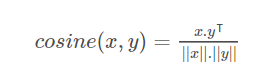


---


- Since we have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the Cosine Similarity Score. Therefore, we will use sklearn's linear_kernel instead of cosine_similarities since it is much faster.

In [ ]:
# 참고 자료... 다시 확인해보자.
# https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=jinp7&logNo=220928044542

In [70]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [71]:
cosine_sim[0]

array([1.        , 0.00680476, 0.        , ..., 0.        , 0.00344913,
       0.        ])

In [ ]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [ ]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [ ]:
get_recommendations('The Godfather').head(10)

973      The Godfather: Part II
8387                 The Family
3509                       Made
4196         Johnny Dangerously
29               Shanghai Triad
5667                       Fury
2412             American Movie
1582    The Godfather: Part III
4221                    8 Women
2159              Summer of Sam
Name: title, dtype: object

In [ ]:
get_recommendations('The Dark Knight').head(10)

7931                      The Dark Knight Rises
132                              Batman Forever
1113                             Batman Returns
8227    Batman: The Dark Knight Returns, Part 2
7565                 Batman: Under the Red Hood
524                                      Batman
7901                           Batman: Year One
2579               Batman: Mask of the Phantasm
2696                                        JFK
8165    Batman: The Dark Knight Returns, Part 1
Name: title, dtype: object

# Metadata Based Recommender


In [ ]:
credits = pd.read_csv('/content/drive/MyDrive/KaggleData/movie/credits.csv')
keywords = pd.read_csv('/content/drive/MyDrive/KaggleData/movie/keywords.csv')

In [ ]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
md['id'] = md['id'].astype('int')

In [ ]:
md.shape

(45463, 25)

In [ ]:
md = md.merge(credits, on='id')
md = md.merge(keywords, on='id')

In [ ]:
smd = md[md['id'].isin(links_small)]
smd.shape

(9219, 28)

In [ ]:
smd['cast'] = smd['cast'].apply(literal_eval)
smd['crew'] = smd['crew'].apply(literal_eval)
smd['keywords'] = smd['keywords'].apply(literal_eval)
smd['cast_size'] = smd['cast'].apply(lambda x: len(x))
smd['crew_size'] = smd['crew'].apply(lambda x: len(x))

In [ ]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [ ]:
smd['director'] = smd['crew'].apply(get_director)

In [ ]:
smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['cast'] = smd['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

In [ ]:
smd['keywords'] = smd['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [ ]:
smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [ ]:
smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
smd['director'] = smd['director'].apply(lambda x: [x,x, x])

## Keywords

In [ ]:
s = smd.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'

In [ ]:
s = s.value_counts()
s[:5]

independent film        610
woman director          550
murder                  399
duringcreditsstinger    327
based on novel          318
Name: keyword, dtype: int64

In [ ]:
s = s[s > 1]

In [ ]:
stemmer = SnowballStemmer('english')
stemmer.stem('dogs')

'dog'

In [ ]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [ ]:
smd['keywords'] = smd['keywords'].apply(filter_keywords)
smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smd['keywords'] = smd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [ ]:
smd['soup'] = smd['keywords'] + smd['cast'] + smd['director'] + smd['genres']
smd['soup'] = smd['soup'].apply(lambda x: ' '.join(x))

In [ ]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(smd['soup'])

In [ ]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [ ]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [ ]:
get_recommendations('The Dark Knight').head(10)

8031         The Dark Knight Rises
6218                 Batman Begins
6623                  The Prestige
2085                     Following
7648                     Inception
4145                      Insomnia
3381                       Memento
8613                  Interstellar
7659    Batman: Under the Red Hood
1134                Batman Returns
Name: title, dtype: object

In [ ]:
get_recommendations('Mean Girls').head(10)

3319               Head Over Heels
4763                 Freaky Friday
1329              The House of Yes
6277              Just Like Heaven
7905         Mr. Popper's Penguins
7332    Ghosts of Girlfriends Past
6959     The Spiderwick Chronicles
8883                      The DUFF
6698         It's a Boy Girl Thing
7377       I Love You, Beth Cooper
Name: title, dtype: object